In [6]:
import pandas as pd
import chardet

import pandas as pd
df = pd.read_csv('C:/Users/Admin/TNTT/spam-5 (1).csv')
df.sample(5) 

,v1,v2
1165,ham,Nhắc nhở: Cuộc họp nhóm sẽ diễn ra vào 14h chi...
1101,ham,Thầy cô gửi thông báo về việc cập nhật sách gi...
1363,ham,"**""Chào anh Quân, Em đã liên hệ với bên vận ch..."
369,ham,Tôi đã nhận được thông tin về dự án và sẽ phản...
1097,ham,Bạn đã được thêm vào lớp học lập trình cơ bản....


In [7]:
df.groupby('v1').describe()

v2                                                               
     count unique                                                top freq
v1                                                                       
ham    639    638  Lên kế hoạch cho cuộc họp tiếp theo. Đừng quên...    2
spam   742    741  Chúng tôi gửi đến bạn món quà trị giá 100 triệ...    2

In [8]:
df_spam = df[df['v1'] == 'spam']
df_spam.shape

(742, 2)

In [9]:
df_ham = df[df['v1'] == 'ham']
df_ham.shape

(640, 2)

In [10]:
df_spam_downsampled = df_spam.sample(df_ham.shape[0])
df_spam_downsampled.shape

(640, 2)

In [11]:
import pandas as pd
df_balanced = pd.concat([df_ham, df_spam_downsampled])
df_balanced.shape

(1280, 2)

In [12]:
df_balanced.sample(5)

,v1,v2
718,spam,"""Ứng dụng yêu thích của bạn vừa được cập nhật...."
1053,ham,Kế hoạch tuần tới đã được cập nhật. Vui lòng k...
539,spam,Siêu giảm giá vào cuối tuần này! Sản phẩm giảm...
515,ham,Cuộc họp sáng nay sẽ tập trung vào kế hoạch tr...
345,spam,Tham gia chương trình và nhận ngay thẻ quà tặn...


In [13]:
df_balanced.groupby('v1').describe()

v2                                                               
     count unique                                                top freq
v1                                                                       
ham    639    638  Lên kế hoạch cho cuộc họp tiếp theo. Đừng quên...    2
spam   640    640  **"Tăng cường sức khỏe với sản phẩm collagen n...    1

In [14]:
if 'v1' in df_balanced.columns:
    df_balanced['label_num'] = df_balanced['v1'].map({'ham':0, 'spam':1})
    print(df_balanced.sample(10))
else:
    print("khum cóa")

        v1                                                 v2  label_num
1215   ham  Kính gửi quý phụ huynh, Nhằm hỗ trợ các em học...          0
475    ham  Chúng ta sẽ có cuộc họp vào chiều nay để thảo ...          0
1146  spam  Hàng ngàn sản phẩm đồ chơi trẻ em giảm giá 40%...          1
1368   ham  **"Chào anh Phong, Báo cáo phân tích dữ liệu d...          0
124   spam  Tôi biết bạn đang tìm kiếm một món quà tuyệt v...          1
389   spam  Hãy tham gia cuộc thi của chúng tôi và có cơ h...          1
1169   ham  Chương trình từ thiện của tổ chức sẽ tổ chức p...          0
1265   ham  **"Anh Hùng thân mến, Đây là email xác nhận đặ...          0
1282   ham  Anh Bình thân mến, Đây là email xác nhận đăng ...          0
388   spam  Nhanh tay đăng ký để nhận ngay voucher trị giá...          1


In [15]:
import pandas as pd
import numpy as np
import re
import torch
from pyvi import ViTokenizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from scipy.stats import randint, uniform
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [20]:

class Tienxulyvippro(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords_file='vietnamesestopwords.txt'):
        with open(stopwords_file, 'r', encoding='utf-8') as f:
            self.stopwords = set(f.read().splitlines())
        self.tudonspam = Counter()
        self.tudonham = Counter()
        self.tughepspam = Counter()
        self.tughepham = Counter()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self._preprocess_text(text) for text in X]

    def _preprocess_text(self, text, update_vocab=False, label=None):
        if not isinstance(text, str):
            text = str(text)
        text = text.lower()
        text = re.sub(r'\d+', 'NUM', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = text.strip()
        tokens = ViTokenizer.tokenize(text).split()
        tokens = [word for word in tokens if word not in self.stopwords]

        if update_vocab and label is not None:
            for token in tokens:
                if '_' in token:  # Từ ghép
                    if label == 1:
                        self.tughepspam[token] += 1
                    else:
                        self.tughepham[token] += 1
                else:  # Từ đơn
                    if label == 1:
                        self.tudonspam[token] += 1
                    else:
                        self.tudonham[token] += 1
        return ' '.join(tokens)

# Usage
processor = Tienxulyvippro()
df_balanced['tokens'] = df_balanced.apply(lambda row: processor._preprocess_text(text=row['v2'], update_vocab=True, label=row['label_num']), axis=1)
print("Từ đơn Spam:", processor.tudonspam)
print("Từ đơn Ham:", processor.tudonham)
print("Từ ghép Spam:", processor.tughepspam)
print("Từ ghép Ham:", processor.tughepham)

Từ đơn Spam: Counter({'NUM': 467, 'vnđ': 191, 'triệu': 151, 'tặng': 133, 'NUMNUM': 131, 'quà': 126, 'nhấn': 106, 'mua': 95, 'thẻ': 63, 'đồng': 61, 'trúng': 52, 'tải': 47, 'lỡ': 46, 'khóa': 44, 'hàng': 43, 'học': 41, 'giá': 41, 'đừng': 39, 'thưởng': 37, 'NUMNUMNUM': 31, 'voucher': 29, 'gói': 28, 'vé': 27, 'gọi': 26, 'abc': 24, 'thi': 23, 'online': 22, 'hotline': 20, 'chuyến': 20, 'tuần': 19, 'app': 17, 'tiền': 15, 'chào': 14, 'iphone': 14, 'đơn': 14, 'chờ': 13, 'xyz': 13, 'cân': 12, 'tỷ': 12, 'da': 12, 'vòng': 11, 'giúp': 11, 'siêu': 11, 'phiếu': 11, 'thử': 10, 'giải': 10, 'sốc': 10, 'nhấp': 10, 'yêu': 9, 'gửi': 9, 'mùa': 9, 'usd': 9, 'mã': 9, 'lịch': 9, 'cực': 9, 'món': 9, 'click': 9, 'link': 9, 'tập': 8, 'đồ': 8, 'laptop': 8, 'phim': 8, 'ví': 7, 'mời': 7, 'vnđtháng': 7, 'vay': 7, 'ảnh': 6, 'website': 6, 'gym': 6, 'tour': 6, 'tết': 6, 'kiếm': 6, 'phòng': 5, 'nâng': 5, 'kính': 5, 'hoàn': 5, 'tiếng': 5, 'sh': 5, 'đêm': 5, 'tri': 5, 'ân': 5, 'thắng': 5, 'ngàn': 5, 'hạn': 5, 'nhật': 4, 'mạ

In [34]:
import json
with open("tudonspam.json", "w", encoding="utf-8") as f:
    json.dump(dict(processor.tudonspam), f, ensure_ascii=False, indent=4)

with open("tudonham.json", "w", encoding="utf-8") as f:
    json.dump(dict(processor.tudonham), f, ensure_ascii=False, indent=4)

with open("tughepspam.json", "w", encoding="utf-8") as f:
    json.dump(dict(processor.tughepspam), f, ensure_ascii=False, indent=4)

with open("tughepham.json", "w", encoding="utf-8") as f:
    json.dump(dict(processor.tughepham), f, ensure_ascii=False, indent=4)


In [35]:


class TextLengthExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        return np.array([[len(text)] for text in texts])

class UppercaseRatioExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        return np.array([[sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0] for text in texts])

def create_feature_extractor():
    return FeatureUnion([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=10000)),
        ('text_length', TextLengthExtractor()),
        ('uppercase_ratio', UppercaseRatioExtractor())
    ])



In [36]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.base import BaseEstimator, TransformerMixin

class PhoBertFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='vinai/phobert-base', max_length=256):
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.model.eval()
        features = []
        
        with torch.no_grad():
            for text in X:
                inputs = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length')
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                outputs = self.model(**inputs)
                pooled_output = outputs.last_hidden_state.mean(dim=1)
                features.append(pooled_output.cpu().numpy().flatten())

        return features

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

def create_model():
    return RandomForestClassifier(random_state=42)

def tune_model(model, X_train, y_train):
    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': [None] + list(range(10, 50)),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 20),
        'max_features': [None, 'sqrt', 'log2'],
        'bootstrap': [True, False],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    }

    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=100,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       128
           1       0.90      0.95      0.93       128

    accuracy                           0.93       256
   macro avg       0.93      0.93      0.93       256
weighted avg       0.93      0.93      0.93       256



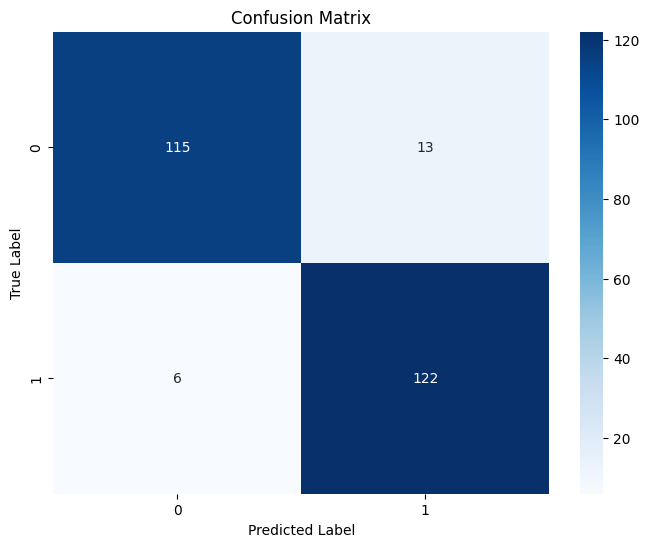

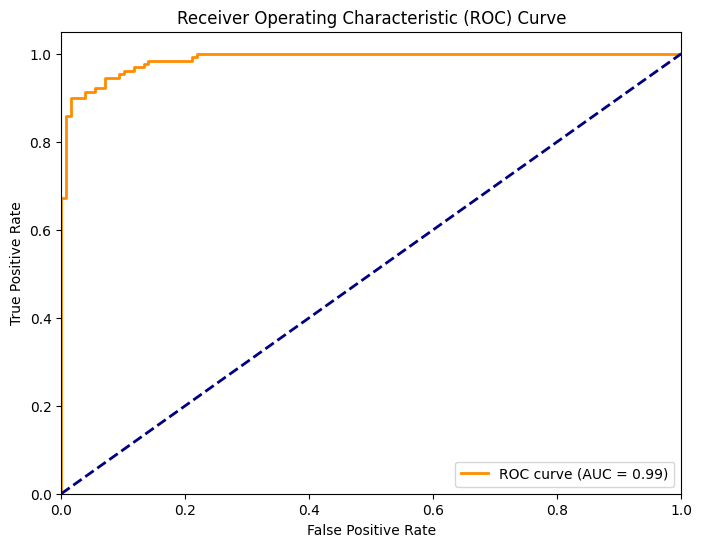

In [43]:

def main():
    
    # Preprocess data
    preprocessor = Tienxulyvippro()
    X = preprocessor.fit_transform(df_balanced['v2'])
    y = df_balanced['v1'].map({'ham': 0, 'spam': 1})
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Extract features
    feature_extractor = create_feature_extractor()
    X_train_features = feature_extractor.fit_transform(X_train)
    X_test_features = feature_extractor.transform(X_test)
    
    # Create and tune model
    model = create_model()
    tuned_model = tune_model(model, X_train_features, y_train)
    
    # Evaluate model
    evaluate_model(tuned_model, X_test_features, y_test)

if __name__ == "__main__":
    main()